In [120]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import random
import skops.io as sio
import itertools as it
import gc
from sklearn.metrics import accuracy_score

O dataset é constituído por imagens de dimensões 32 x 32 x 3 com os 3 canais RGB

In [121]:
def load(arr, path):
    for filename in os.listdir(path):
        arr.append(np.reshape(cv2.imread(os.path.join(path, filename)), (3072,)))

In [122]:
if not os.path.exists("test.txt"):
    test_x = []
    load(test_x, "test/FAKE/")
    load(test_x, "test/REAL/")
    train_x = []
    load(train_x, "train/FAKE/")
    load(train_x, "train/REAL/")
    # Os dados são salvos como arquivo binário para acelerar a leitura dos dados
    # na próxima leitura
    np.array(test_x, dtype=np.uint8).tofile("test.txt")
    np.array(train_x, dtype=np.uint8).tofile("train.txt")

Os dados são números inteiros de 0 a 255 representando o valor de cada pixel, para normalizar os dados precisamos apenas dividir todos os valores por 255

In [123]:
test_x = np.fromfile("test.txt", dtype=np.uint8).reshape((20000, 32, 32, 3)) / 255
train_x = np.fromfile("train.txt", dtype=np.uint8).reshape((100000,32, 32,3)) / 255
print(test_x.shape, train_x.shape)

(20000, 32, 32, 3) (100000, 32, 32, 3)


Os dados estão distribuídos de forma que a primeira metade dos dados faz parte da classe falsa e a segunda metade da classe real. Os vetores y são preenchidos com 0s e 1s de acordo com as classes

In [124]:
test_y = np.append(np.zeros((10000,)), np.ones((10000,)))
train_y = np.append(np.zeros((50000,)), np.ones((50000,)))
print(test_y.shape, train_y.shape)

(20000,) (100000,)


As imagens que compõem o dataset são imagens de aviões, automóveis, pássaros, cervos, gatos, cachorros, sapos, cavalos, navios e caminhões. Todas as imagens tem características diferentes não seguindo padrões aparentes

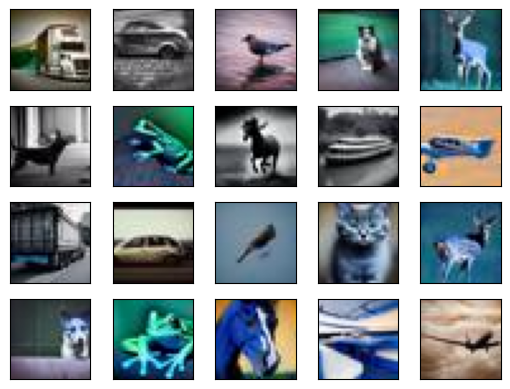

In [125]:
for i in range(1,21):
    plt.subplot(4, 5, i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(test_x[i-1])

In [126]:
def auxiliar_data(data_x:np.ndarray, data_y, size):
    size = int(size/2)
    half = int(len(data_x) / 2)
    indexes = list(range(half-size, half+size))
    random.shuffle(indexes)
    return (data_x[indexes],data_y[indexes])


In [127]:
flat_train_x = train_x.reshape(len(train_x), 3072)
flat_test_x = test_x.reshape(len(test_x), 3072)

### A primeira solução para resolver o problema vai ser o modelo de K-vizinhos mais próximos

In [128]:
from sklearn.neighbors import KNeighborsClassifier

In [129]:
if os.path.exists("final_knn_score.npy"):
    knn_proba = sio.loads(sio.load('knn_proba'))
    with open('final_knn_score.npy', 'rb') as f:
        final_knn_score = np.load(f, allow_pickle=True).flatten()[0]
else:
    knn_model = KNeighborsClassifier(n_neighbors=19, n_jobs=-1)
    knn_model.fit(flat_train_x, train_y)
    knn_proba = knn_model.predict_proba(flat_test_x)
    final_knn_score = accuracy_score(np.argmax(knn_proba, 1), test_y)
    sio.dump(sio.dumps(knn_proba), 'knn_proba')
    with open('final_knn_score.npy', 'wb') as f:
        np.save(f, np.array(final_knn_score,dtype=object), allow_pickle=True)
final_knn_score

0.696

O modelo knn funciona de forma simples, ele agrupa os valores de acordo com as suas proximidade e faz predições calculando a proximidade do valor de entrada com os grupos

In [130]:
xx, yy = auxiliar_data(np.fromfile("test.txt", dtype=np.uint8).reshape(20000, 3072), test_y, 3000)
xx = xx[:, :2]
knn_model = KNeighborsClassifier(n_neighbors=20, n_jobs=-1)
knn_model.fit(xx, yy)
None

In [131]:
xx_test_ax = np.array(list(it.product(range(0, 256, 5), repeat=2)))
xx_ax = xx_test_ax.transpose()[0]
xx_ay = xx_test_ax.transpose()[1]


Visualização das áreas formadas por agrupamento do knn

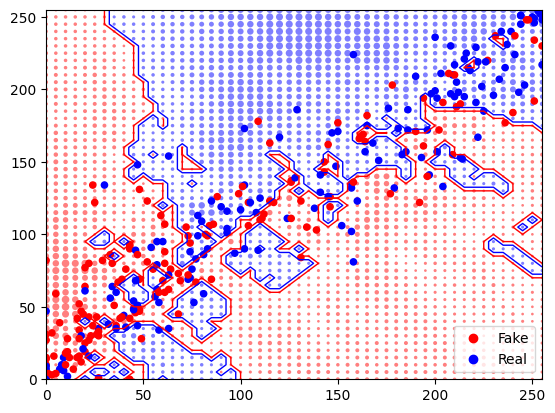

In [132]:
colors_map = ['r', 'b']
proba = knn_model.predict_proba(xx_test_ax)
nm = int(np.sqrt(xx_test_ax.shape[0]))
z = np.transpose([[proba[i*nm+j].argmax() for j in range(nm)] for i in range(nm)])
sizes = np.max(proba, axis=1)**3 * 30
colors = [colors_map[int(x)] for x in knn_model.predict(xx_test_ax)]
plt.scatter(xx_ax, xx_ay,s=sizes, c=colors, linewidths=0, alpha=0.5)
plt.contour(range(0,256,5), range(0,256,5), z, linewidths=1, levels=1, colors=colors_map)

count = 300
colors = [colors_map[int(x)] for x in yy[:count]]
plt.scatter(xx[:count,0], xx[:count, 1],c=colors, s=20)
plt.legend([plt.Line2D([0], [0], linestyle='', marker='o', color='r'),
           plt.Line2D([0], [0], linestyle='', marker='o', color='b')], ['Fake', 'Real'], loc='lower right')
None

### O próximo modelo a ser usado é o de Árvore de decisão

In [133]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [134]:
if os.path.exists('tree_model.skops'):
    tree_model = sio.loads(sio.load("tree_model.skops", trusted=True), trusted=True)
else:
    tree_model = DecisionTreeClassifier(max_depth=2)
    tree_model.fit(flat_train_x, train_y)
    sio.dump(sio.dumps(tree_model), "tree_model.skops")
tree_model.score(flat_test_x, test_y)

0.605

A arvore de decisão cria uma árvore binária e divide os nós baseados nas condições definidas pelo algoritmo, a predição de novas entradas é feita apenas realizando uma 'busca' na árvore com a entrada

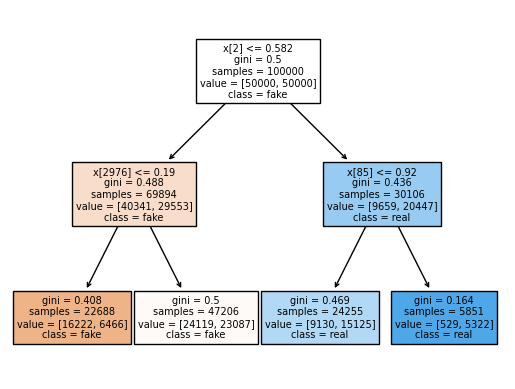

In [135]:
plot_tree(tree_model, class_names=['fake', 'real'],filled=True)
None

In [136]:
tree_xx, tree_yy = auxiliar_data(flat_test_x, test_y, 2000)
tree_model_vis = DecisionTreeClassifier(max_depth=2)
tree_model_vis.fit(tree_xx[:, :2], tree_yy)
None


In [137]:
children_left = tree_model_vis.tree_.children_left
children_right = tree_model_vis.tree_.children_right
feature = tree_model_vis.tree_.feature
threshold = tree_model_vis.tree_.threshold
classes = tree_model_vis.tree_.value

limits = [[(0,1), (0,1)]]
stack = [0]
decisions = []
while len(stack) > 0:
    limit_x, limit_y = limits.pop()
    i = stack.pop()
    is_split_node = children_left[i] != children_right[i]
    
    if not is_split_node:
        continue
    
    left_class = np.argmax(classes[children_left[i]][0])
    right_class = np.argmax(classes[children_right[i]][0])
    if feature[i] == 0:
        limits.append([limit_x, (threshold[i], limit_y[1])])
        limits.append([limit_x, (limit_y[0], threshold[i])])
        a = [limit_x[0], limit_x[0], limit_x[1], limit_x[1]]
        b = [limit_y[0], threshold[i], threshold[i], limit_y[0]]
        decisions.append([a, b, left_class])
        b = [limit_y[1], threshold[i], threshold[i], limit_y[1]]
        decisions.append([a, b, right_class])
    else:
        limits.append([(threshold[i], limit_x[1]), limit_y])
        limits.append([(limit_x[0], threshold[i]), limit_y])
        a = [limit_x[0], threshold[i], threshold[i], limit_x[0]]
        b = [limit_y[0], limit_y[0], limit_y[1], limit_y[1]]
        decisions.append([a, b, left_class])
        a = [limit_x[1], threshold[i], threshold[i], limit_x[1]]
        decisions.append([a, b, right_class])
    stack.append(children_right[i])
    stack.append(children_left[i])


Toda divisão feita na arvora pode ser visualizada como uma área

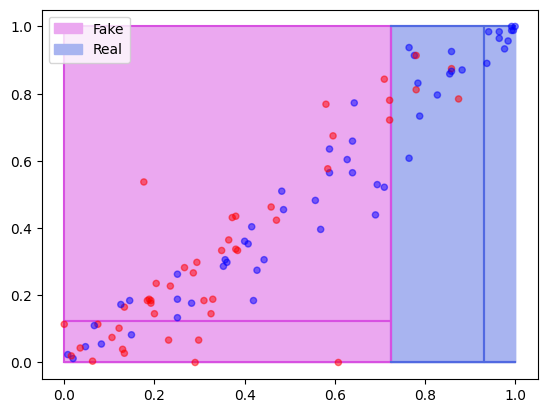

In [138]:
c_map1 = ['#eba8f0', '#a8b4f0']
c_map2 = ['#d751e1', '#5169e1']
c_map3 = ['r', 'b']
for d in decisions:
    plt.fill(d[0],d[1], c=c_map1[d[2]], zorder=1)
    plt.plot(d[0],d[1], c=c_map2[d[2]], zorder=2)
plt.legend([plt.Polygon([[0, 0]], color=c_map1[0]), plt.Polygon([[0, 0]], color=c_map1[1])], ['Fake', 'Real'], loc='upper left')

count = 100
plt.scatter(tree_xx[:count,1], tree_xx[:count,0], c=[c_map3[int(y)] for y in tree_yy[:count]], s=20, alpha=0.5, zorder=3)

In [139]:
tree_proba = tree_model.predict_proba(flat_test_x)

### O terceiro modelo é a Rede neural artificial

In [140]:
import tensorflow as tf
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, ReLU
from keras.models import Sequential, load_model
from keras.optimizers import Adamax
from keras.losses import SparseCategoricalCrossentropy

In [141]:
ann_model = Sequential()

ann_model.add(Dense(64))
ann_model.add(ReLU())
ann_model.add(Dense(32))
ann_model.add(ReLU())
ann_model.add(Dense(16))
ann_model.add(ReLU())
ann_model.add(Dense(2, activation="sigmoid"))

In [142]:
ann_model.compile(optimizer=Adamax(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])

In [143]:
if os.path.exists('ann_model'):
    ann_model = load_model('ann_model')
    with open('ann_fit.txt', 'r') as f:
        print(f.read())
else:
    ann_model.fit(flat_test_x, test_y, epochs=10, validation_split=0.2, use_multiprocessing=True)
    ann_model.save('ann_model')

Epoch 1/10
500/500 [==============================] - 15s 17ms/step - loss: 0.6363 - acc: 0.6317 - val_loss: 0.6574 - val_acc: 0.5970
Epoch 2/10
500/500 [==============================] - 7s 14ms/step - loss: 0.5822 - acc: 0.6784 - val_loss: 0.8123 - val_acc: 0.4778
Epoch 3/10
500/500 [==============================] - 7s 15ms/step - loss: 0.5442 - acc: 0.7157 - val_loss: 0.9646 - val_acc: 0.3885
Epoch 4/10
500/500 [==============================] - 7s 15ms/step - loss: 0.5214 - acc: 0.7334 - val_loss: 0.8669 - val_acc: 0.4900
Epoch 5/10
500/500 [==============================] - 7s 15ms/step - loss: 0.5056 - acc: 0.7513 - val_loss: 0.6781 - val_acc: 0.6298
Epoch 6/10
500/500 [==============================] - 7s 15ms/step - loss: 0.4968 - acc: 0.7531 - val_loss: 0.8732 - val_acc: 0.5023
Epoch 7/10
500/500 [==============================] - 7s 14ms/step - loss: 0.4894 - acc: 0.7586 - val_loss: 0.4748 - val_acc: 0.7930
Epoch 8/10
500/500 [==============================] - 7s 13ms/step -

As redes neurais usam regressão para treinar o modelo e atualizar os pesos dos neurônios de forma que suas saídas se aproximem do esperado

In [144]:
ann_model.evaluate(flat_test_x, test_y)

625/625 [==============================] - 3s 5ms/step - loss: 0.5186 - acc: 0.7438


[0.5186100602149963, 0.7437999844551086]

In [145]:
ann_proba = ann_model.predict(flat_test_x, use_multiprocessing=True)

625/625 [==============================] - 3s 4ms/step


In [146]:
def normalize_matrix(matrix):
    mn, mx = matrix.min(), matrix.max()
    if(mn < 0):
        mn *= -1
    else:
        mn = 0
    return (matrix+mn)/(mx+mn)


In [147]:
weights, bias = ann_model.layers[0].get_weights()

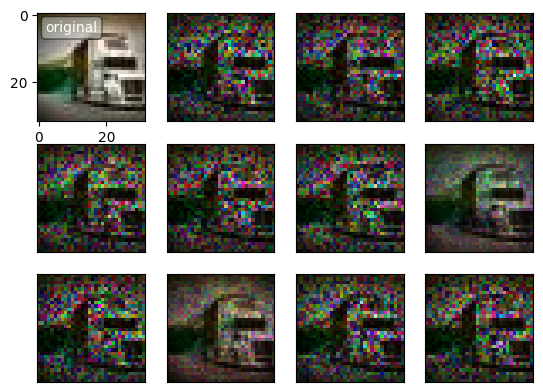

In [148]:
plt.subplot(3, 4, 1)
plt.imshow(test_x[0])
plt.annotate("original",[2,5], color='w', bbox={'boxstyle': 'round', 'fc': '0.8', 'alpha': 0.5})
for i in range(2, 13):
    processed_img = weights[:, i-2].reshape(32, 32, 3)
    processed_img = normalize_matrix(processed_img)
    processed_img = np.multiply(processed_img, test_x[0])
    plt.subplot(3,4,i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(processed_img)


In [149]:
processed_img = Sequential(layers=ann_model.layers[:2]).predict(flat_test_x[:1])
processed_img = normalize_matrix(processed_img.reshape((8, 8)))


1/1 [==============================] - 0s 120ms/step


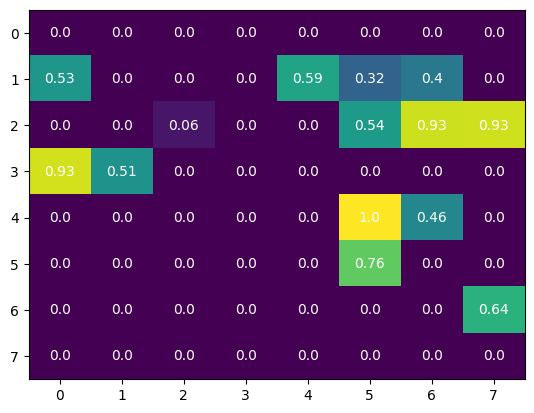

In [150]:
plt.imshow(processed_img, interpolation='nearest', aspect='auto')

for x in range(len(processed_img)):
    for y in range(len(processed_img[x])):
            plt.text(y,x, round(processed_img[x][y], 2), ha="center",va='center', color="w")

### O quarto e último modelo é a Rede neural convolucional

In [151]:
cnn_model = Sequential()

cnn_model.add(Conv2D(16, 3, input_shape=(32,32,3)))
cnn_model.add(ReLU())
cnn_model.add(MaxPool2D())
cnn_model.add(Conv2D(16, 3))
cnn_model.add(ReLU())
cnn_model.add(MaxPool2D())

cnn_model.add(Flatten())
cnn_model.add(Dense(64))
cnn_model.add(ReLU())
cnn_model.add(Dense(32))
cnn_model.add(ReLU())
cnn_model.add(Dense(16))
cnn_model.add(ReLU())
cnn_model.add(Dense(2, activation="sigmoid"))

In [152]:
cnn_model.compile(optimizer=Adamax(), loss=SparseCategoricalCrossentropy(), metrics=["accuracy"])

In [153]:
if os.path.exists('cnn_model'):
    cnn_model = load_model('cnn_model')
    with open('cnn_fit.txt', 'r') as f:
        print(f.read())
else:
    cnn_model.fit(train_x, train_y, epochs=5, use_multiprocessing=True, batch_size=64, validation_split=0.2)
    cnn_model.save("cnn_model")


Epoch 1/5
1250/1250 [==============================] - 48s 37ms/step - loss: 0.4351 - accuracy: 0.7940 - val_loss: 0.7671 - val_accuracy: 0.6345
Epoch 2/5
1250/1250 [==============================] - 46s 37ms/step - loss: 0.3143 - accuracy: 0.8659 - val_loss: 0.3162 - val_accuracy: 0.8781
Epoch 3/5
1250/1250 [==============================] - 45s 36ms/step - loss: 0.2704 - accuracy: 0.8869 - val_loss: 0.5036 - val_accuracy: 0.7842
Epoch 4/5
1250/1250 [==============================] - 45s 36ms/step - loss: 0.2453 - accuracy: 0.8987 - val_loss: 0.3701 - val_accuracy: 0.8444
Epoch 5/5
1250/1250 [==============================] - 47s 37ms/step - loss: 0.2277 - accuracy: 0.9068 - val_loss: 0.3153 - val_accuracy: 0.8717


In [154]:
cnn_model.evaluate(test_x, test_y, use_multiprocessing=True)

625/625 [==============================] - 7s 11ms/step - loss: 0.2377 - accuracy: 0.9026


[0.23769311606884003, 0.902649998664856]

In [155]:
cnn_proba = cnn_model.predict(test_x, use_multiprocessing=True)

625/625 [==============================] - 7s 11ms/step


In [156]:
filters, bias = cnn_model.layers[0].get_weights()

Além das camadas densas, nas CNNs usamos filtros e operações de convolução aplicadas a imagem para extrair características importantes da imagem

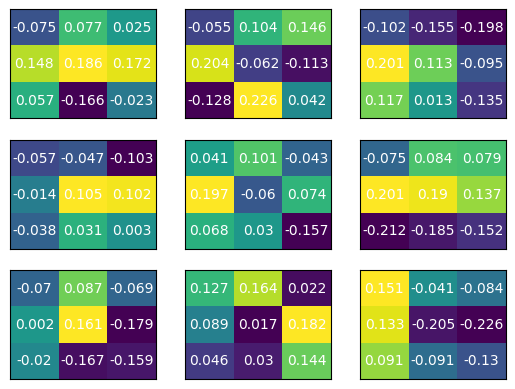

In [157]:
for i in range(1,10):
    plt.subplot(3,3,i)
    f = filters[:,:,0,i-1]
    plt.xticks([])
    plt.yticks([])
    plt.imshow(f, aspect='auto', interpolation='nearest')

    for x in range(len(f)):
        for y in range(len(f[x])):
            text = plt.text(y,x, round(f[x][y], 3),
                   ha="center",va='center', color="w")


In [158]:
feature_maps = Sequential(layers=cnn_model.layers[:1]).predict(test_x[2:3])

1/1 [==============================] - 0s 104ms/step


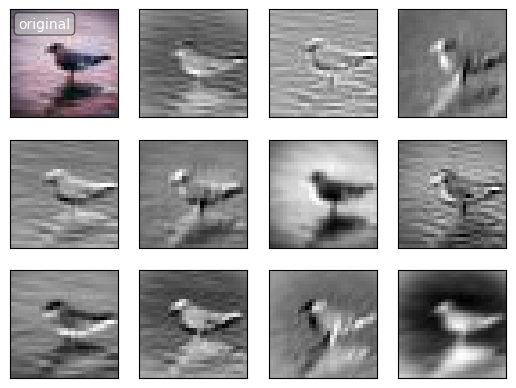

In [160]:
plt.subplot(3,4,1)
plt.xticks([])
plt.yticks([])
plt.imshow(test_x[2])
plt.annotate("original",[2,5], color='w', bbox={'boxstyle': 'round', 'fc': '0.8', 'alpha': 0.5})

for i in range(2,13):
    plt.subplot(3,4,i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(feature_maps[0][:,:,i], cmap='gray')

In [161]:
from sklearn.metrics import roc_auc_score, roc_curve

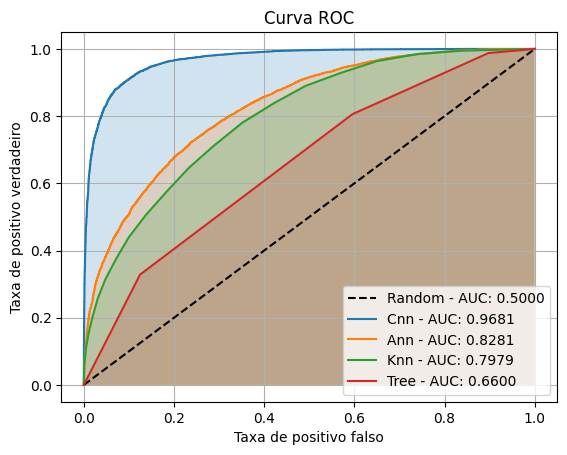

In [162]:
plt.plot([0,1], [0,1], '--', color='black', label='Random - AUC: 0.5000')
for proba, name in zip([cnn_proba, ann_proba,knn_proba, tree_proba], ['Cnn', 'Ann', 'Knn', 'Tree' ]):
    fpr, tpr, _ = roc_curve(test_y, proba.transpose()[0])
    auc = str(round(1 - roc_auc_score(test_y, proba.transpose()[0]), 4)).ljust(6, '0')
    plt.fill([*tpr, tpr[-1]], [*fpr, 0], alpha=0.2)
    plt.plot(tpr, fpr, label=f'{name} - AUC: {auc}')
    plt.legend(loc='lower right')
plt.ylabel('Taxa de positivo verdadeiro')
plt.xlabel('Taxa de positivo falso')
plt.title('Curva ROC')
plt.grid()
